# Imports

In [1]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import json
pd.options.display.max_columns = 9999999

In [3]:
data = []

with gzip.open('movielens_5_injected_G60.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
len(data)

105000

In [5]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 874724710, 'u': 'bottom_255', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 60, 'bip': True, 'cost': 0.0}
{'t': 874724727, 'u': 'bottom_286', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 60, 'bip': True, 'cost': 0.0}
{'t': 874724754, 'u': 'bottom_298', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 60, 'bip': True, 'cost': 0.0}
{'t': 874724781, 'u': 'bottom_185', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 60, 'bip': True, 'cost': 0.0, 'top_number_of_nodes': 3, 'top_degrees_nb_one': 3, 'top_degrees_nb_two': 0, 'top_degrees_min': 1, 'top_degrees_max': 1, 'top_degrees_median': 1, 'top_weighted_degrees_nb_one': 3, 'top_weighted_degrees_nb_two': 0, 'top_weighted_degrees_min': 1, 'top_weighted_degrees_max': 1, 'top_weighted_degrees_median': 1, 'bot_number_of_nodes': 1, 'bot_degrees_nb_one': 0, 'bot_degrees_nb_two': 0, 'bot_degrees_min': 3, 'bot_degrees_max': 3, 'bot_degrees_median': 3, 'bot_weigh

# Flatten the internal `O(1)` features

In [6]:
from utilitiesMe import flatten_dict

In [7]:
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [8]:
data_flattened[0]

{'t': 874724710,
 'u': 'bottom_255',
 'v': 'top_259',
 'is_fraud': 0,
 'history_type': 'G',
 'history_size': 60,
 'bip': True,
 'cost': 0.0}

# Convert flattened json to dataframe

In [9]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [10]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,60,True,0.0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
4,874724843,bottom_173,top_259,0,G,60,True,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,G,60,True,0.0,8.0,8.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,6.0,2.0,0.0,1.0,2.0,6.0,2.0,1.0,6.0,8.0,1.0,0.0,0.0,1.0,6.0,8.0,1.0,0.0,0.0,8.0,8.0,8.0,0.0,1.0,1.0,1.0,1.0,8.0,0.0
104996,893286638,bottom_328,top_729,0,G,60,True,0.0,9.0,9.0,0.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,7.0,2.0,0.0,1.0,2.0,7.0,2.0,1.0,7.0,9.0,1.0,0.0,0.0,1.0,7.0,9.0,1.0,0.0,0.0,9.0,9.0,9.0,0.0,1.0,1.0,1.0,1.0,9.0,0.0
104997,893286638,bottom_333,top_729,0,G,60,True,0.0,10.0,10.0,0.0,1.0,1.0,1.0,10.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,8.0,2.0,0.0,1.0,2.0,8.0,2.0,1.0,8.0,10.0,1.0,0.0,0.0,1.0,8.0,10.0,1.0,0.0,0.0,10.0,10.0,10.0,0.0,1.0,1.0,1.0,1.0,10.0,0.0
104998,893286638,bottom_689,top_729,0,G,60,True,0.0,11.0,11.0,0.0,1.0,1.0,1.0,11.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,9.0,2.0,0.0,1.0,2.0,9.0,2.0,1.0,9.0,11.0,1.0,0.0,0.0,1.0,9.0,11.0,1.0,0.0,0.0,11.0,11.0,11.0,0.0,1.0,1.0,1.0,1.0,11.0,0.0


In [11]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,60,True,0.0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
4,874724843,bottom_173,top_259,0,G,60,True,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,G,60,True,0.0,8.0,8.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,6.0,2.0,0.0,1.0,2.0,6.0,2.0,1.0,6.0,8.0,1.0,0.0,0.0,1.0,6.0,8.0,1.0,0.0,0.0,8.0,8.0,8.0,0.0,1.0,1.0,1.0,1.0,8.0,0.0
104996,893286638,bottom_328,top_729,0,G,60,True,0.0,9.0,9.0,0.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,7.0,2.0,0.0,1.0,2.0,7.0,2.0,1.0,7.0,9.0,1.0,0.0,0.0,1.0,7.0,9.0,1.0,0.0,0.0,9.0,9.0,9.0,0.0,1.0,1.0,1.0,1.0,9.0,0.0
104997,893286638,bottom_333,top_729,0,G,60,True,0.0,10.0,10.0,0.0,1.0,1.0,1.0,10.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,8.0,2.0,0.0,1.0,2.0,8.0,2.0,1.0,8.0,10.0,1.0,0.0,0.0,1.0,8.0,10.0,1.0,0.0,0.0,10.0,10.0,10.0,0.0,1.0,1.0,1.0,1.0,10.0,0.0
104998,893286638,bottom_689,top_729,0,G,60,True,0.0,11.0,11.0,0.0,1.0,1.0,1.0,11.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,9.0,2.0,0.0,1.0,2.0,9.0,2.0,1.0,9.0,11.0,1.0,0.0,0.0,1.0,9.0,11.0,1.0,0.0,0.0,11.0,11.0,11.0,0.0,1.0,1.0,1.0,1.0,11.0,0.0


In [12]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.050000e+05,105000.000000,105000.0,105000.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.0,104997.0,104997.0,104997.0,104997.0,104997.000000,104997.0
mean,8.835258e+08,0.047619,60.0,0.000006,5.765812,5.750536,0.015162,1.000038,1.013153,1.000038,5.750536,0.015162,1.000038,1.013153,1.000038,1.561397,0.496233,0.211930,3.344467,4.753498,3.470613,0.496233,0.211930,3.344467,4.753498,3.470613,1.002219,4.410840,5.727002,1.074088,0.012648,0.129185,1.002219,4.410840,5.727002,1.074088,0.012648,0.129185,5.781251,5.781251,5.781251,0.0,1.0,1.0,1.0,1.0,5.781251,0.0
std,5.345223e+06,0.212960,0.0,0.000301,4.356957,4.318518,0.141352,0.006172,0.115754,0.006172,4.318518,0.141352,0.006172,0.115754,0.006172,1.018335,0.723206,0.446328,2.975066,3.194210,2.942421,0.723206,0.446328,2.975066,3.194210,2.942421,0.047858,3.195189,4.300519,0.315520,0.130175,0.431900,0.047858,3.195189,4.300519,0.315520,0.130175,0.431900,4.400428,4.400428,4.400428,0.0,0.0,0.0,0.0,0.0,4.400428,0.0
min,8.747247e+08,0.000000,60.0,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,1.0,1.000000,0.0
25%,8.794484e+08,0.000000,60.0,0.000000,3.000000,3.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000,3.000000,3.000000,3.000000,0.0,1.0,1.0,1.0,1.0,3.000000,0.0
50%,8.828265e+08,0.000000,60.0,0.000000,5.000000,5.000000,0.000000,1.000000,1.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,4.000000,3.000000,0.000000,0.000000,2.000000,4.000000,3.000000,1.000000,4.000000,5.000000,1.000000,0.000000,0.000000,1.000000,4.000000,5.000000,1.000000,0.000000,0.000000,5.000000,5.000000,5.000000,0.0,1.0,1.0,1.0,1.0,5.000000,0.0
75%,8.882664e+08,0.000000,60.0,0.000000,8.000000,8.000000,0.000000,1.000000,1.000000,1.000000,8.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,5.000000,6.000000,5.000000,1.000000,0.000000,5.000000,6.000000,5.000000,1.000000,6.000000,8.000000,1.000000,0.000000,0.000000,1.000000,6.000000,8.000000,1.000000,0.000000,0.000000,8.000000,8.000000,8.000000,0.0,1.0,1.0,1.0,1.0,8.000000,0.0
max,8.932866e+0

# Remove NaNs

In [13]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,60,True,0.0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
4,874724843,bottom_173,top_259,0,G,60,True,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,874724882,bottom_108,top_259,0,G,60,True,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
6,874724882,bottom_772,top_259,0,G,60,True,0.0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
7,874724905,bottom_288,top_259,0,G,60,True,0.0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
8,874724937,bottom_928,top_259,0,G,60,True,0.0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0,4.0,1.0,4.0,4.0,1.0,0.0,0.0,1.0,4.0,4.0,1.0,0.0,0.0,4.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,4.0,0.0
9,874724988,bottom_117,top_259,0,G,60,True,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0


In [14]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
3,874724781,bottom_185,top_259,0,G,60,True,0.0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
4,874724843,bottom_173,top_259,0,G,60,True,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,874724882,bottom_108,top_259,0,G,60,True,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
6,874724882,bottom_772,top_259,0,G,60,True,0.0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
7,874724905,bottom_288,top_259,0,G,60,True,0.0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,G,60,True,0.0,8.0,8.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,6.0,2.0,0.0,1.0,2.0,6.0,2.0,1.0,6.0,8.0,1.0,0.0,0.0,1.0,6.0,8.0,1.0,0.0,0.0,8.0,8.0,8.0,0.0,1.0,1.0,1.0,1.0,8.0,0.0
104996,893286638,bottom_328,top_729,0,G,60,True,0.0,9.0,9.0,0.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,7.0,2.0,0.0,1.0,2.0,7.0,2.0,1.0,7.0,9.0,1.0,0.0,0.0,1.0,7.0,9.0,1.0,0.0,0.0,9.0,9.0,9.0,0.0,1.0,1.0,1.0,1.0,9.0,0.0
104997,893286638,bottom_333,top_729,0,G,60,True,0.0,10.0,10.0,0.0,1.0,1.0,1.0,10.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,8.0,2.0,0.0,1.0,2.0,8.0,2.0,1.0,8.0,10.0,1.0,0.0,0.0,1.0,8.0,10.0,1.0,0.0,0.0,10.0,10.0,10.0,0.0,1.0,1.0,1.0,1.0,10.0,0.0
104998,893286638,bottom_689,top_729,0,G,60,True,0.0,11.0,11.0,0.0,1.0,1.0,1.0,11.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,9.0,2.0,0.0,1.0,2.0,9.0,2.0,1.0,9.0,11.0,1.0,0.0,0.0,1.0,9.0,11.0,1.0,0.0,0.0,11.0,11.0,11.0,0.0,1.0,1.0,1.0,1.0,11.0,0.0


In [15]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,60,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.049970e+05,104997.000000,104997.0,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.0,104997.0,104997.0,104997.0,104997.0,104997.000000,104997.0
mean,8.835261e+08,0.047620,60.0,0.000006,5.765812,5.750536,0.015162,1.000038,1.013153,1.000038,5.750536,0.015162,1.000038,1.013153,1.000038,1.561397,0.496233,0.211930,3.344467,4.753498,3.470613,0.496233,0.211930,3.344467,4.753498,3.470613,1.002219,4.410840,5.727002,1.074088,0.012648,0.129185,1.002219,4.410840,5.727002,1.074088,0.012648,0.129185,5.781251,5.781251,5.781251,0.0,1.0,1.0,1.0,1.0,5.781251,0.0
std,5.345092e+06,0.212963,0.0,0.000301,4.356957,4.318518,0.141352,0.006172,0.115754,0.006172,4.318518,0.141352,0.006172,0.115754,0.006172,1.018335,0.723206,0.446328,2.975066,3.194210,2.942421,0.723206,0.446328,2.975066,3.194210,2.942421,0.047858,3.195189,4.300519,0.315520,0.130175,0.431900,0.047858,3.195189,4.300519,0.315520,0.130175,0.431900,4.400428,4.400428,4.400428,0.0,0.0,0.0,0.0,0.0,4.400428,0.0
min,8.747248e+08,0.000000,60.0,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,1.0,1.000000,0.0
25%,8.794485e+08,0.000000,60.0,0.000000,3.000000,3.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000,3.000000,3.000000,3.000000,0.0,1.0,1.0,1.0,1.0,3.000000,0.0
50%,8.828266e+08,0.000000,60.0,0.000000,5.000000,5.000000,0.000000,1.000000,1.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,4.000000,3.000000,0.000000,0.000000,2.000000,4.000000,3.000000,1.000000,4.000000,5.000000,1.000000,0.000000,0.000000,1.000000,4.000000,5.000000,1.000000,0.000000,0.000000,5.000000,5.000000,5.000000,0.0,1.0,1.0,1.0,1.0,5.000000,0.0
75%,8.882664e+08,0.000000,60.0,0.000000,8.000000,8.000000,0.000000,1.000000,1.000000,1.000000,8.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,5.000000,6.000000,5.000000,1.000000,0.000000,5.000000,6.000000,5.000000,1.000000,6.000000,8.000000,1.000000,0.000000,0.000000,1.000000,6.000000,8.000000,1.000000,0.000000,0.000000,8.000000,8.000000,8.000000,0.0,1.0,1.0,1.0,1.0,8.000000,0.0
max,8.932866e+0

In [17]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
3,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
4,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
6,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
7,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,8.0,8.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,6.0,2.0,0.0,1.0,2.0,6.0,2.0,1.0,6.0,8.0,1.0,0.0,0.0,1.0,6.0,8.0,1.0,0.0,0.0,8.0,8.0,8.0,0.0,1.0,1.0,1.0,1.0,8.0,0.0
104996,0,9.0,9.0,0.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,7.0,2.0,0.0,1.0,2.0,7.0,2.0,1.0,7.0,9.0,1.0,0.0,0.0,1.0,7.0,9.0,1.0,0.0,0.0,9.0,9.0,9.0,0.0,1.0,1.0,1.0,1.0,9.0,0.0
104997,0,10.0,10.0,0.0,1.0,1.0,1.0,10.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,8.0,2.0,0.0,1.0,2.0,8.0,2.0,1.0,8.0,10.0,1.0,0.0,0.0,1.0,8.0,10.0,1.0,0.0,0.0,10.0,10.0,10.0,0.0,1.0,1.0,1.0,1.0,10.0,0.0
104998,0,11.0,11.0,0.0,1.0,1.0,1.0,11.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,9.0,2.0,0.0,1.0,2.0,9.0,2.0,1.0,9.0,11.0,1.0,0.0,0.0,1.0,9.0,11.0,1.0,0.0,0.0,11.0,11.0,11.0,0.0,1.0,1.0,1.0,1.0,11.0,0.0


In [18]:
df_features.describe()

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.000000,104997.0,104997.0,104997.0,104997.0,104997.0,104997.000000,104997.0
mean,0.047620,5.765812,5.750536,0.015162,1.000038,1.013153,1.000038,5.750536,0.015162,1.000038,1.013153,1.000038,1.561397,0.496233,0.211930,3.344467,4.753498,3.470613,0.496233,0.211930,3.344467,4.753498,3.470613,1.002219,4.410840,5.727002,1.074088,0.012648,0.129185,1.002219,4.410840,5.727002,1.074088,0.012648,0.129185,5.781251,5.781251,5.781251,0.0,1.0,1.0,1.0,1.0,5.781251,0.0
std,0.212963,4.356957,4.318518,0.141352,0.006172,0.115754,0.006172,4.318518,0.141352,0.006172,0.115754,0.006172,1.018335,0.723206,0.446328,2.975066,3.194210,2.942421,0.723206,0.446328,2.975066,3.194210,2.942421,0.047858,3.195189,4.300519,0.315520,0.130175,0.431900,0.047858,3.195189,4.300519,0.315520,0.130175,0.431900,4.400428,4.400428,4.400428,0.0,0.0,0.0,0.0,0.0,4.400428,0.0
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,1.0,1.000000,0.0
25%,0.000000,3.000000,3.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000,3.000000,3.000000,3.000000,0.0,1.0,1.0,1.0,1.0,3.000000,0.0
50%,0.000000,5.000000,5.000000,0.000000,1.000000,1.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,4.000000,3.000000,0.000000,0.000000,2.000000,4.000000,3.000000,1.000000,4.000000,5.000000,1.000000,0.000000,0.000000,1.000000,4.000000,5.000000,1.000000,0.000000,0.000000,5.000000,5.000000,5.000000,0.0,1.0,1.0,1.0,1.0,5.000000,0.0
75%,0.000000,8.000000,8.000000,0.000000,1.000000,1.000000,1.000000,8.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,5.000000,6.000000,5.000000,1.000000,0.000000,5.000000,6.000000,5.000000,1.000000,6.000000,8.000000,1.000000,0.000000,0.000000,1.000000,6.000000,8.000000,1.000000,0.000000,0.000000,8.000000,8.000000,8.000000,0.0,1.0,1.0,1.0,1.0,8.000000,0.0
max,1.000000,41.000000,40.000000,4.000000,2.000000,4.000000,2.000000,40.000000,4.000000,2.000000,4.000000,2.000000,11.000000,7.000000,5.000000,30.000000,30.000000,30.000000,7.000000,5.000000,30.000000,30.000000,30.000000,4.000000,30.000000,

In [19]:
df_target = df["is_fraud"]
df_target

3         0
4         0
5         0
6         0
7         0
         ..
104995    0
104996    0
104997    0
104998    0
104999    0
Name: is_fraud, Length: 104997, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [20]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [21]:
len(train_df) + len(test_df) == len(df)

True

In [22]:
train_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
3,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
4,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
6,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
7,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73496,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
73497,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
73498,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
73499,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0


In [23]:
test_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
73501,0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0,4.0,1.0,4.0,4.0,1.0,0.0,0.0,1.0,4.0,4.0,1.0,0.0,0.0,4.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,4.0,0.0
73502,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
73503,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
73504,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
73505,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,8.0,8.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,6.0,2.0,0.0,1.0,2.0,6.0,2.0,1.0,6.0,8.0,1.0,0.0,0.0,1.0,6.0,8.0,1.0,0.0,0.0,8.0,8.0,8.0,0.0,1.0,1.0,1.0,1.0,8.0,0.0
104996,0,9.0,9.0,0.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,7.0,2.0,0.0,1.0,2.0,7.0,2.0,1.0,7.0,9.0,1.0,0.0,0.0,1.0,7.0,9.0,1.0,0.0,0.0,9.0,9.0,9.0,0.0,1.0,1.0,1.0,1.0,9.0,0.0
104997,0,10.0,10.0,0.0,1.0,1.0,1.0,10.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,8.0,2.0,0.0,1.0,2.0,8.0,2.0,1.0,8.0,10.0,1.0,0.0,0.0,1.0,8.0,10.0,1.0,0.0,0.0,10.0,10.0,10.0,0.0,1.0,1.0,1.0,1.0,10.0,0.0
104998,0,11.0,11.0,0.0,1.0,1.0,1.0,11.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,9.0,2.0,0.0,1.0,2.0,9.0,2.0,1.0,9.0,11.0,1.0,0.0,0.0,1.0,9.0,11.0,1.0,0.0,0.0,11.0,11.0,11.0,0.0,1.0,1.0,1.0,1.0,11.0,0.0


### Undersampling and training on `X_train, y_train`

In [24]:
train_df["is_fraud"].value_counts()

0    70008
1     3490
Name: is_fraud, dtype: int64

In [25]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [26]:
print(len(nonanomalous))
print(len(anomalous))

70008
3490


In [27]:
print(nonanomalous.shape)
print(anomalous.shape)

(70008, 45)
(3490, 45)


In [28]:
train_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.612616,5.600688,0.011756,1.000057,1.010727,1.000057,5.600688,0.011756,1.000057,1.010727,1.000057,1.470161,0.428094,0.206476,3.453405,4.745015,3.569292,0.428094,0.206476,3.453405,4.745015,3.569292,1.001985,4.530111,5.582319,1.048809,0.009656,0.079919,1.001985,4.530111,5.582319,1.048809,0.009656,0.079919,5.624786,5.624786,5.624786,0.0,1.0,1.0,1.0,1.0,5.624786,0.0
1,5.011748,5.003438,0.008309,1.000000,1.007450,1.000000,5.003438,0.008309,1.000000,1.007450,1.000000,2.271920,1.434957,0.217192,1.002006,3.469054,1.125215,1.434957,0.217192,1.002006,3.469054,1.125215,1.001433,1.002579,4.999713,1.436390,0.006877,0.834957,1.001433,1.002579,4.999713,1.436390,0.006877,0.834957,5.020057,5.020057,5.020057,0.0,1.0,1.0,1.0,1.0,5.020057,0.0


In [29]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [30]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [31]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
29360,0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0,4.0,1.0,4.0,4.0,1.0,0.0,0.0,1.0,4.0,4.0,1.0,0.0,0.0,4.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,4.0,0.0
15735,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
38530,0,7.0,7.0,0.0,1.0,1.0,1.0,7.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,7.0,7.0,0.0,0.0,7.0,7.0,7.0,1.0,7.0,7.0,1.0,0.0,0.0,1.0,7.0,7.0,1.0,0.0,0.0,7.0,7.0,7.0,0.0,1.0,1.0,1.0,1.0,7.0,0.0
39369,0,5.0,5.0,0.0,1.0,1.0,1.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,5.0,5.0,5.0,1.0,5.0,5.0,1.0,0.0,0.0,1.0,5.0,5.0,1.0,0.0,0.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0
50531,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73366,1,6.0,6.0,0.0,1.0,1.0,1.0,6.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,5.0,1.0,1.0,0.0,1.0,5.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,6.0,6.0,6.0,0.0,1.0,1.0,1.0,1.0,6.0,0.0
73386,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
73396,1,5.0,5.0,0.0,1.0,1.0,1.0,5.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,4.0,1.0,1.0,0.0,1.0,4.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0
73408,1,6.0,6.0,0.0,1.0,1.0,1.0,6.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,5.0,1.0,1.0,0.0,1.0,5.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,6.0,6.0,6.0,0.0,1.0,1.0,1.0,1.0,6.0,0.0


Author: Now the rows of the `nonanomalous` are random

In [32]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    3490
1    3490
Name: is_fraud, dtype: int64

In [33]:
new_dataset.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.599140,5.583381,0.015186,1.0,1.013754,1.0,5.583381,0.015186,1.0,1.013754,1.0,1.480802,0.423782,0.211748,3.432092,4.679943,3.564183,0.423782,0.211748,3.432092,4.679943,3.564183,1.002006,4.459885,5.565903,1.058453,0.013467,0.083954,1.002006,4.459885,5.565903,1.058453,0.013467,0.083954,5.615473,5.615473,5.615473,0.0,1.0,1.0,1.0,1.0,5.615473,0.0
1,5.011748,5.003438,0.008309,1.0,1.007450,1.0,5.003438,0.008309,1.0,1.007450,1.0,2.271920,1.434957,0.217192,1.002006,3.469054,1.125215,1.434957,0.217192,1.002006,3.469054,1.125215,1.001433,1.002579,4.999713,1.436390,0.006877,0.834957,1.001433,1.002579,4.999713,1.436390,0.006877,0.834957,5.020057,5.020057,5.020057,0.0,1.0,1.0,1.0,1.0,5.020057,0.0


In [34]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
29360,0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0,4.0,1.0,4.0,4.0,1.0,0.0,0.0,1.0,4.0,4.0,1.0,0.0,0.0,4.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,4.0,0.0
15735,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
38530,0,7.0,7.0,0.0,1.0,1.0,1.0,7.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,7.0,7.0,0.0,0.0,7.0,7.0,7.0,1.0,7.0,7.0,1.0,0.0,0.0,1.0,7.0,7.0,1.0,0.0,0.0,7.0,7.0,7.0,0.0,1.0,1.0,1.0,1.0,7.0,0.0
39369,0,5.0,5.0,0.0,1.0,1.0,1.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,5.0,5.0,5.0,1.0,5.0,5.0,1.0,0.0,0.0,1.0,5.0,5.0,1.0,0.0,0.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0
50531,0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73366,1,6.0,6.0,0.0,1.0,1.0,1.0,6.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,5.0,1.0,1.0,0.0,1.0,5.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,6.0,6.0,6.0,0.0,1.0,1.0,1.0,1.0,6.0,0.0
73386,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
73396,1,5.0,5.0,0.0,1.0,1.0,1.0,5.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,4.0,1.0,1.0,0.0,1.0,4.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0
73408,1,6.0,6.0,0.0,1.0,1.0,1.0,6.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,5.0,1.0,1.0,0.0,1.0,5.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,6.0,6.0,6.0,0.0,1.0,1.0,1.0,1.0,6.0,0.0


In [35]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
12595,1,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
38780,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
16994,1,9.0,9.0,0.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,8.0,1.0,1.0,0.0,1.0,8.0,1.0,1.0,1.0,9.0,1.0,0.0,1.0,1.0,1.0,9.0,1.0,0.0,1.0,9.0,9.0,9.0,0.0,1.0,1.0,1.0,1.0,9.0,0.0
73206,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
23979,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,1,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
35503,1,6.0,6.0,0.0,1.0,1.0,1.0,6.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,5.0,1.0,1.0,0.0,1.0,5.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,1.0,1.0,6.0,1.0,0.0,1.0,6.0,6.0,6.0,0.0,1.0,1.0,1.0,1.0,6.0,0.0
36332,1,12.0,12.0,0.0,1.0,1.0,1.0,12.0,0.0,1.0,1.0,1.0,4.0,2.0,0.0,1.0,6.0,1.0,2.0,0.0,1.0,6.0,1.0,1.0,1.0,12.0,2.0,0.0,2.0,1.0,1.0,12.0,2.0,0.0,2.0,12.0,12.0,12.0,0.0,1.0,1.0,1.0,1.0,12.0,0.0
39587,1,5.0,5.0,0.0,1.0,1.0,1.0,5.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,4.0,1.0,1.0,0.0,1.0,4.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0


In [36]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [37]:
test_df["is_fraud"].value_counts()

0    29989
1     1510
Name: is_fraud, dtype: int64

In [38]:
test_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6.211244,6.187569,0.023675,1.0,1.019240,1.0,6.187569,0.023675,1.0,1.019240,1.0,1.644170,0.493981,0.221715,3.480776,4.972290,3.629931,0.493981,0.221715,3.480776,4.972290,3.629931,1.002834,4.700657,6.150222,1.067925,0.020107,0.119544,1.002834,4.700657,6.150222,1.067925,0.020107,0.119544,6.234919,6.234919,6.234919,0.0,1.0,1.0,1.0,1.0,6.234919,0.0
1,5.764901,5.745033,0.019868,1.0,1.017881,1.0,5.745033,0.019868,1.0,1.017881,1.0,2.505298,1.530464,0.258278,1.000662,3.770199,1.152318,1.530464,0.258278,1.000662,3.770199,1.152318,1.002649,1.002649,5.710596,1.531126,0.016556,0.973510,1.002649,1.002649,5.710596,1.531126,0.016556,0.973510,5.784768,5.784768,5.784768,0.0,1.0,1.0,1.0,1.0,5.784768,0.0


In [39]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [40]:
test_df["is_fraud"].value_counts()

0    29989
1     1510
Name: is_fraud, dtype: int64

In [41]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9756


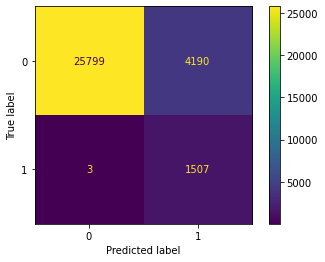

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

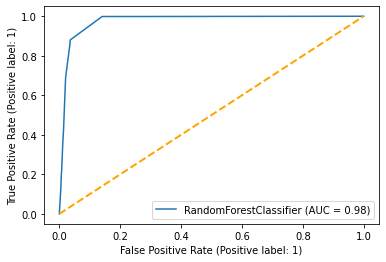

In [43]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [46]:
X

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
3,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
4,3.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104992,8.0,8.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,6.0,2.0,0.0,1.0,2.0,6.0,2.0,1.0,6.0,8.0,1.0,0.0,0.0,1.0,6.0,8.0,1.0,0.0,0.0,8.0,8.0,8.0,0.0,1.0,1.0,1.0,1.0,8.0,0.0
104993,9.0,9.0,0.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,7.0,2.0,0.0,1.0,2.0,7.0,2.0,1.0,7.0,9.0,1.0,0.0,0.0,1.0,7.0,9.0,1.0,0.0,0.0,9.0,9.0,9.0,0.0,1.0,1.0,1.0,1.0,9.0,0.0
104994,10.0,10.0,0.0,1.0,1.0,1.0,10.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,8.0,2.0,0.0,1.0,2.0,8.0,2.0,1.0,8.0,10.0,1.0,0.0,0.0,1.0,8.0,10.0,1.0,0.0,0.0,10.0,10.0,10.0,0.0,1.0,1.0,1.0,1.0,10.0,0.0
104995,11.0,11.0,0.0,1.0,1.0,1.0,11.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,9.0,2.0,0.0,1.0,2.0,9.0,2.0,1.0,9.0,11.0,1.0,0.0,0.0,1.0,9.0,11.0,1.0,0.0,0.0,11.0,11.0,11.0,0.0,1.0,1.0,1.0,1.0,11.0,0.0


In [47]:
y

0         0
1         0
2         0
3         0
4         0
         ..
104992    0
104993    0
104994    0
104995    0
104996    0
Name: is_fraud, Length: 104997, dtype: int64

In [48]:
len(df) / 2

52498.5

In [49]:
len(df)

104997

In [50]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 1049 



In [51]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    try:
        roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    except ValueError as e:
        continue

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 1049 

RangeIndex(start=0, stop=52498, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 2044, 2044
Counts of y = 1 and y = 0 in y_test: 485, 10015
0
Iteration difference 52498: ROC-AUC=0.9704
------------------------------------------------------------------------------------------------
RangeIndex(start=1049, stop=53547, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 2046, 2046
Counts of y = 1 and y = 0 in y_test: 481, 10019
1049
Iteration difference 52498: ROC-AUC=0.9711
------------------------------------------------------------------------------------------------
RangeIndex(start=2098, stop=54596, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 2059, 2059
Counts of y = 1 and y = 0 in y_test: 479, 10021
2098
Iteration difference 52498: ROC-AUC=0.9754
------------------------------------------------------------------------------------------------
RangeIndex(start=3147, stop=55645, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 2056

28323
Iteration difference 52498: ROC-AUC=0.9822
------------------------------------------------------------------------------------------------
RangeIndex(start=29372, stop=81870, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1965, 1965
Counts of y = 1 and y = 0 in y_test: 503, 9997
29372
Iteration difference 52498: ROC-AUC=0.9830
------------------------------------------------------------------------------------------------
RangeIndex(start=30421, stop=82919, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1986, 1986
Counts of y = 1 and y = 0 in y_test: 490, 10010
30421
Iteration difference 52498: ROC-AUC=0.9823
------------------------------------------------------------------------------------------------
RangeIndex(start=31470, stop=83968, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1990, 1990
Counts of y = 1 and y = 0 in y_test: 497, 10003
31470
Iteration difference 52498: ROC-AUC=0.9811
-------------------------------------------------

In [52]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
104995,893286638,bottom_689,top_729,0,G,60,True,0.0,11.0,11.0,0.0,1.0,1.0,1.0,11.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,9.0,2.0,0.0,1.0,2.0,9.0,2.0,1.0,9.0,11.0,1.0,0.0,0.0,1.0,9.0,11.0,1.0,0.0,0.0,11.0,11.0,11.0,0.0,1.0,1.0,1.0,1.0,11.0,0.0
104996,893286638,bottom_748,top_729,0,G,60,True,0.0,12.0,12.0,0.0,1.0,1.0,1.0,12.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,10.0,2.0,0.0,1.0,2.0,10.0,2.0,1.0,10.0,12.0,1.0,0.0,0.0,1.0,10.0,12.0,1.0,0.0,0.0,12.0,12.0,12.0,0.0,1.0,1.0,1.0,1.0,12.0,0.0


In [53]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("MovieLens-5Perc-G60-AUCInSlidingWindow.xlsx", index=False)

In [54]:
len(roc_auc_results)

51

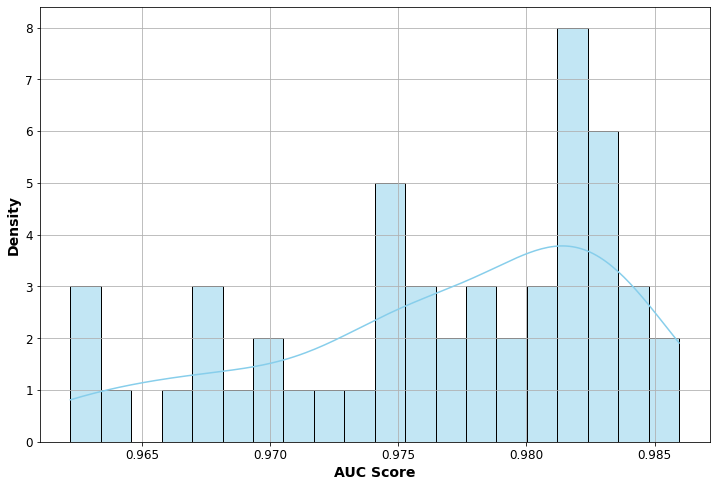

In [55]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()